In [41]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.metrics import mean_squared_error
import holidays
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import optuna
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import xgboost as xgb
from statsmodels.tsa.filters.hp_filter import hpfilter

In [52]:
data = pd.read_csv("train_temporary_dtw.csv")

In [53]:
data

,TM,branch_ID,TA,WD,WS,RN_DAY,RN_HR1,HM,SI,ta_chi,heat_demand
0,2021010101,A,-10.1,78.3,0.5,0.0,0.0,68.2,0.0,-8.2,281.0
1,2021010102,A,-10.2,71.9,0.6,0.0,0.0,69.9,0.0,-8.6,262.0
2,2021010103,A,-10.0,360.0,0.0,0.0,0.0,69.2,0.0,-8.8,266.0
3,2021010104,A,-9.3,155.9,0.5,0.0,0.0,65.0,0.0,-8.9,285.0
4,2021010105,A,-9.0,74.3,1.9,0.0,0.0,63.5,0.0,-9.2,283.0
...,...,...,...,...,...,...,...,...,...,...,...
499296,2023123119,S,3.2,233.5,0.4,2.5,0.0,91.5,0.0,2.8,34.0
499297,2023123120,S,2.9,227.4,0.1,2.5,0.0,92.1,0.0,2.7,35.0
499298,2023123121,S,2.1,360.0,0.0,2.5,0.0,93.3,0.0,1.4,35.0
499299,2023123122,S,2.2,30.0,1.4,2.5,0.0,95.5,0.0,1.3,40.0


### 파생변수 생성
1. 평일,주말
2. 공휴일

In [54]:
# 요일 추출 (0=월요일, 6=일요일)
data['TM'] = pd.to_datetime(data['TM'], format='%Y%m%d%H')
data['year'] = data['TM'].dt.year
data['month'] = data['TM'].dt.month
data['day'] = data['TM'].dt.day
data['hour'] = data['TM'].dt.hour

data['weekday'] = data['TM'].dt.weekday

# 평일/주말 구분 (0=평일, 1=주말)
data['is_weekend'] = (data['weekday'] >= 5).astype(int)

# 한국 공휴일 설정
korea_holidays = holidays.Korea(years=range(2021, 2025))

# 공휴일 여부 (1=공휴일, 0=평일)
data['is_holiday'] = data['TM'].dt.date.apply(lambda x: x in korea_holidays).astype(int)

data.drop("weekday",axis=1, inplace=True)
data.head()

,TM,branch_ID,TA,WD,WS,RN_DAY,RN_HR1,HM,SI,ta_chi,heat_demand,year,month,day,hour,is_weekend,is_holiday
0,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,0.0,-8.2,281.0,2021,1,1,1,0,1
1,2021-01-01 02:00:00,A,-10.2,71.9,0.6,0.0,0.0,69.9,0.0,-8.6,262.0,2021,1,1,2,0,1
2,2021-01-01 03:00:00,A,-10.0,360.0,0.0,0.0,0.0,69.2,0.0,-8.8,266.0,2021,1,1,3,0,1
3,2021-01-01 04:00:00,A,-9.3,155.9,0.5,0.0,0.0,65.0,0.0,-8.9,285.0,2021,1,1,4,0,1
4,2021-01-01 05:00:00,A,-9.0,74.3,1.9,0.0,0.0,63.5,0.0,-9.2,283.0,2021,1,1,5,0,1


In [55]:
def add_fourier_features(df, col, period, order=3, prefix=None):
    """
    Append 2*order Fourier terms for a cyclical column.

    Parameters
    ----------
    df      : pd.DataFrame              (original data)
    col     : str                       (column holding integers 0-(P-1) or 1-P)
    period  : int                       (cycle length, e.g. 24 for hour, 12 for month)
    order   : int, default 3            (# harmonics K)
    prefix  : str or None               (prefix for new columns; defaults to `col`)
    """
    prefix = prefix or col
    out = df.copy()
    x = out[col].astype(float)

    for k in range(1, order + 1):
        angle = 2.0 * np.pi * k * x / period
        out[f"{prefix}_sin{k}"] = np.sin(angle)
        out[f"{prefix}_cos{k}"] = np.cos(angle)
    return out

# Hour
data = add_fourier_features(data, col='hour', period=24, order=2, prefix='hour')

# Month
data = add_fourier_features(data, col='month', period=12, order=2, prefix='month')



data['days_in_month'] = data['TM'].dt.days_in_month

def fourier_dom(df, order=3, day_col='day', period_col='days_in_month', prefix='dom'):
    out = df.copy()
    d   = out[day_col].astype(float)
    P   = out[period_col].astype(float)
    for k in range(1, order + 1):
        angle = 2 * np.pi * k * d / P
        out[f'{prefix}_sin{k}'] = np.sin(angle)
        out[f'{prefix}_cos{k}'] = np.cos(angle)
    return out

data = fourier_dom(data, order=2,prefix='day')

3. 불쾌지수(DI)  
DI = 0.4×(Ta + Tw) + 15  → 일반적인 식  
Ta : 건구온도  
Tw : 습구온도 (없을 시 밑의 식으로)  

DI = 9/5×Ta - 0.55×(1 - RH)×(9/5×Ta - 26) + 32  
RH : 상대습도 (소수 단위)

In [56]:
def calculate_DI(ta, hm):
    hm = hm / 100
    DI = 1.8*ta - 0.55*(1 - hm)*(1.8*ta - 26) +32
    return DI

In [57]:
def DI_level(di):
    if di < 68:
        return 0  # 전원 쾌적
    elif di < 70:
        return 1  # 불쾌감 나타남  
    elif di < 75:
        return 2  # 10% 정도 불쾌
    elif di < 80:
        return 3  # 50% 정도 불쾌
    elif di < 83:
        return 4  # 전원 불쾌
    else:
        return 5  # 매우 불쾌

In [58]:
data['DI'] = calculate_DI(data['TA'], data['HM'])
data['Discomfort_level'] = data['DI'].apply(DI_level)

4. 난방도일 (HDD) 

원래는 일별로 구하지만 그렇게 하면 같은 값이 24개씩 반복되기 때문에 시간별 난방도일로 계산

In [59]:
def create_HDD_features(
    data: pd.DataFrame,
    *,
    branch_col: str = "branch_ID",   # 그룹 구분 열
    temp_col: str   = "TA",          # 시간별 실외 온도
    time_col: str   = "TM",          # 타임스탬프
    base_temp: int  = 18,            # 기준 온도(°C)
    windows: tuple  = (7, 30)        # 누적 일수(예: 7일·30일)
) -> pd.DataFrame:
    df = data.copy()

    df = df.sort_values([branch_col, time_col])

    # 3) 시간별 HDH = (base – TA)^+    (음수면 0으로 잘림)
    df["hourly_HDH"] = (base_temp - df[temp_col]).clip(lower=0)

    # 4) 최근 N일 누적 HDD — 그룹별 rolling 합계
    for days in windows:
        hours = 24 * days                        # 창 크기(시간)
        df[f"rolling_HDD_{days}d"] = (
            df
            .groupby(branch_col, observed=True)["hourly_HDH"]
            .transform(lambda s: s.rolling(window=hours, min_periods=1).sum())
        )

    return df

# 사용
data = create_HDD_features(
    data,            # 원본 DataFrame
    branch_col="branch_ID",
    temp_col="TA",
    time_col="TM",
    base_temp=18,
    windows=(7, 30)  # 7일 및 30일 누적 HDD
)

### HP 필터

In [60]:
# 2) 그룹별 HP 필터 함수
def hp_filter_group(group, column="heat_demand", lam=1600):
    """
    한 그룹(branch_ID)에 대해 HP 필터 적용 후 trend·noise 열을 추가해 돌려줌
    """
    noise, trend     = hpfilter(group[column], lamb=lam)
    group            = group.copy()          # 원본 손상 방지
    group["heat_demand_trend"]   = trend
    group["heat_demand_cycle"]   = noise
    return group

# 3) 정렬(시간 순서) → 그룹별 apply → 결과를 하나로
data = (
    data.sort_values(["branch_ID", "TM"])
      .groupby("branch_ID", group_keys=False)
      .apply(hp_filter_group)   # <- 추가
)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16588\3845632937.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(hp_filter_group)   # <- 추가


In [61]:
# lag features 생성
def create_lag_features(df, column, lags):
    """
    Create lag features for a specific column in the DataFrame.
    
    Parameters:
    df (DataFrame): Input DataFrame.
    column (str): Column name to create lag features for.
    lags (list): List of lag periods to create features for.
    
    Returns:
    DataFrame: DataFrame with lag features added.
    """
    for lag in lags:
        df[f'{column}_lag_{lag}'] = df[column].shift(lag)
    return df

lag_dict = {'TA':[1,3,6,12,24], 'HM':[1,2,3], 'WS':[1,3],'SI':[1]}

# grouped by 'branch_ID'

for col, lags in lag_dict.items():
    for lag in lags:
        data[f"{col}_lag_{lag}"] = (
            data
            .groupby("branch_ID")[col]          # 그룹별 시계열
            .transform(lambda s: s.shift(lag))  # 그룹 내부에서만 shift
        )

In [62]:
# 타겟 변수와 피처 분리
target_col = 'heat_demand_cycle'
exclude_cols = ['TM', target_col, 'year','month', 'day','hour','Unnamed: 0','branch_ID',"WD","RN_DAY",'days_in_month', 'heat_demand_trend','heat_demand']
feature_cols = [col for col in data.columns if col not in exclude_cols]

In [63]:
feature_cols

['TA',
 'WS',
 'RN_HR1',
 'HM',
 'SI',
 'ta_chi',
 'is_weekend',
 'is_holiday',
 'hour_sin1',
 'hour_cos1',
 'hour_sin2',
 'hour_cos2',
 'month_sin1',
 'month_cos1',
 'month_sin2',
 'month_cos2',
 'day_sin1',
 'day_cos1',
 'day_sin2',
 'day_cos2',
 'DI',
 'Discomfort_level',
 'hourly_HDH',
 'rolling_HDD_7d',
 'rolling_HDD_30d',
 'TA_lag_1',
 'TA_lag_3',
 'TA_lag_6',
 'TA_lag_12',
 'TA_lag_24',
 'HM_lag_1',
 'HM_lag_2',
 'HM_lag_3',
 'WS_lag_1',
 'WS_lag_3',
 'SI_lag_1']

In [64]:
data.dropna(subset=feature_cols,inplace=True)
len(data)

498845

In [65]:
data['branch_ID'] = data['branch_ID'].astype('category')

print(f"\nTarget 변수: {target_col}")
print(f"사용될 Feature 개수: {len(feature_cols)}")


Target 변수: heat_demand_cycle
사용될 Feature 개수: 36


In [66]:
# 연도 컬럼 추가
data['year'] = pd.to_datetime(data['TM']).dt.year

# 바로 분할
train_data = data[data['year'].isin([2021, 2022])]
val_data = data[data['year'] == 2023]

Branch ID별 모델 학습

In [67]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import optuna
import joblib

def find_best_params_by_branch(data: pd.DataFrame, feature_cols: list, target_col: str) -> dict:
    best_params_dict = {}
    unique_branches = data['branch_ID'].unique()
    
    # 학습용과 검증용 데이터 분리
    train_data = data[data['year'].isin([2021, 2022])].copy()
    val_data = data[data['year'] == 2023].copy()
    
    for branch_id in unique_branches:
        print(f"\n===== Finding Best Parameters for branch_ID: {branch_id} =====")
        
        # 지사별 데이터 필터링
        branch_train = train_data[train_data['branch_ID'] == branch_id].copy()
        branch_val = val_data[val_data['branch_ID'] == branch_id].copy()
        
        # 시계열 순서대로 정렬
        branch_train = branch_train.sort_values('TM').reset_index(drop=True)
        branch_val = branch_val.sort_values('TM').reset_index(drop=True)
        
        X_train = branch_train[feature_cols]
        y_train = branch_train[target_col]
        X_val = branch_val[feature_cols]
        y_val = branch_val[target_col]
        
        # 시계열 교차검증 설정 (학습 데이터 내에서)
        tscv = TimeSeriesSplit(n_splits=5)
        
        # Optuna objective 함수 (CV 적용)
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 500, 5000, step=100),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.7, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
                'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.7, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
                'gamma': trial.suggest_float('gamma', 1e-8, 0.5, log=True),
                'random_state': 42,
                'n_jobs': -1,
                'verbosity': 0
            }
            
            # CV 점수들을 저장할 리스트
            cv_scores = []
            
            # TimeSeriesSplit을 실제로 사용하여 CV 수행
            for train_idx, val_idx in tscv.split(X_train):
                X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                
                # 모델 생성 및 학습
                xgb_model = xgb.XGBRegressor(**params)
                xgb_model.fit(X_fold_train, y_fold_train)
                
                # fold별 예측 및 RMSE 계산
                y_pred = xgb_model.predict(X_fold_val)
                rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
                cv_scores.append(rmse)
            
            # CV 점수들의 평균을 반환 (최적화 목표)
            return np.mean(cv_scores)
        
        print(f"--- Starting Optuna Hyperparameter Tuning for {branch_id} ---")
        
        # Optuna study 생성 및 최적화
        study = optuna.create_study(direction='minimize', 
                                  sampler=optuna.samplers.TPESampler(seed=42))
        study.optimize(objective, n_trials=50)
        
        # 최적 파라미터로 2023 검증 데이터 평가
        best_params = study.best_params.copy()
        best_params.update({
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': 0
        })
        
        final_model = xgb.XGBRegressor(**best_params)
        final_model.fit(X_train, y_train)  # 2021-2022 전체로 학습
        y_val_pred = final_model.predict(X_val)  # 2023으로 예측
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        
        best_params_dict[branch_id] = study.best_params
        print(f"--- Best Parameters for {branch_id}: {study.best_params} ---")
        print(f"--- Best CV RMSE for {branch_id}: {study.best_value:.4f} ---")
        print(f"--- 2023 Validation RMSE for {branch_id}: {val_rmse:.4f} ---")
    
    return best_params_dict

def train_final_models_with_best_params(data: pd.DataFrame, feature_cols: list, target_col: str, best_params_dict: dict) -> dict:
    final_models = {}
    unique_branches = data['branch_ID'].unique()
    
    # 2021-2023 전체 데이터 (최종 학습용)
    full_train_data = data[data['year'].isin([2021, 2022, 2023])].copy()
    
    for branch_id in unique_branches:
        print(f"\n===== Training Final Model for branch_ID: {branch_id} =====")
        
        # 지사별 데이터 필터링 및 정렬
        branch_data = full_train_data[full_train_data['branch_ID'] == branch_id].copy()
        branch_data = branch_data.sort_values('TM').reset_index(drop=True)
        
        X = branch_data[feature_cols]
        y = branch_data[target_col]
        
        # 해당 지사의 최적 파라미터 가져오기
        best_params = best_params_dict[branch_id].copy()
        best_params.update({
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': 0
        })
        
        # 최종 모델 학습
        final_model = xgb.XGBRegressor(**best_params)
        final_model.fit(X, y)
        
        final_models[branch_id] = final_model
        print(f"--- Final model training completed for {branch_id} ---")
    
    return final_models

def predict_with_final_models(data_pred: pd.DataFrame, models: dict, feature_cols: list) -> pd.DataFrame:
    predictions = []
    
    data_pred_sorted = data_pred.sort_values('branch_ID').copy()
    
    for branch_id, group_data in data_pred_sorted.groupby('branch_ID'):
        print(f"--- Predicting for branch_ID: {branch_id} ---")
        
        if branch_id in models:
            model = models[branch_id]
            X_pred = group_data[feature_cols]
            group_predictions = model.predict(X_pred)
            result_data = group_data.copy()
            result_data['prediction'] = group_predictions
            predictions.append(result_data)
    
    final_data = pd.concat(predictions).sort_index()
    return final_data

In [68]:
# 1단계: 2021-2022 학습, 2023 검증으로 최적 파라미터 찾기
print("=" * 60)
print("STEP 1: Finding Best Parameters using 2021-2022 train, 2023 validation")
print("=" * 60)

best_params_dict = find_best_params_by_branch(data, feature_cols, target_col)

# 최적 파라미터 저장
joblib.dump(best_params_dict, 'best_params_by_branch_modify1_cv.joblib')
print(f"\nBest parameters saved for {len(best_params_dict)} branches")

final_models = train_final_models_with_best_params(
    data         = train_data,  # <─ 2023 제외
    feature_cols = feature_cols,
    target_col   = target_col,
    best_params_dict = best_params_dict
)

# 3) 2023 데이터 예측
pred_2023 = predict_with_final_models(
    data_pred    = val_data,  # <─ 2023만 전달
    models       = final_models,
    feature_cols = feature_cols
)
pred_2023 = pred_2023.to_csv('2023_cycle_lag.csv', index=False)

# 2단계: 최적 파라미터로 2021-2023 전체 데이터 재학습
print("\n" + "=" * 60)
print("STEP 2: Training Final Models with 2021-2023 data using best parameters")
print("=" * 60)

final_models = train_final_models_with_best_params(data, feature_cols, target_col, best_params_dict)



# 최종 모델 저장
joblib.dump(final_models, 'final_models_2021_2023_modify1_cv.joblib')
print(f"\nFinal models saved for {len(final_models)} branches")

STEP 1: Finding Best Parameters using 2021-2022 train, 2023 validation


[I 2025-06-27 00:47:01,099] A new study created in memory with name: no-name-dc16a146-2bee-414a-946a-2cdee54052c7



===== Finding Best Parameters for branch_ID: A =====
--- Starting Optuna Hyperparameter Tuning for A ---


[I 2025-06-27 00:47:17,333] Trial 0 finished with value: 10.124702524320385 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 10.124702524320385.
[I 2025-06-27 00:47:33,944] Trial 1 finished with value: 10.326375961319297 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 10.124702524320385.
[I 2025-06-27 00:47:53,735] Trial 2 finished with value: 10.413825448605918 and

--- Best Parameters for A: {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 0.011537876344166672, 'subsample': 0.9503845223785639, 'colsample_bytree': 0.7304415584935621, 'colsample_bylevel': 0.9845797114866024, 'reg_alpha': 9.882602091985438e-07, 'reg_lambda': 0.9159279058212368, 'min_child_weight': 2, 'gamma': 8.886902332748861e-07} ---
--- Best CV RMSE for A: 9.7418 ---
--- 2023 Validation RMSE for A: 8.8845 ---

===== Finding Best Parameters for branch_ID: B =====
--- Starting Optuna Hyperparameter Tuning for B ---


[I 2025-06-27 01:04:06,910] Trial 0 finished with value: 29.30155267659514 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 29.30155267659514.
[I 2025-06-27 01:04:22,223] Trial 1 finished with value: 29.323668679181857 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 29.30155267659514.
[I 2025-06-27 01:04:38,083] Trial 2 finished with value: 29.45509667989945 and par

--- Best Parameters for B: {'n_estimators': 2600, 'max_depth': 10, 'learning_rate': 0.03647049748479232, 'subsample': 0.7462049127237006, 'colsample_bytree': 0.908842624464622, 'colsample_bylevel': 0.7730530034803582, 'reg_alpha': 0.0005375332370114689, 'reg_lambda': 0.9892543136848909, 'min_child_weight': 4, 'gamma': 0.00024044611953267844} ---
--- Best CV RMSE for B: 28.2890 ---
--- 2023 Validation RMSE for B: 23.2939 ---

===== Finding Best Parameters for branch_ID: C =====
--- Starting Optuna Hyperparameter Tuning for C ---


[I 2025-06-27 01:35:59,037] Trial 0 finished with value: 20.97847963192091 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 20.97847963192091.
[I 2025-06-27 01:36:15,372] Trial 1 finished with value: 20.819266939901695 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 1 with value: 20.819266939901695.
[I 2025-06-27 01:36:30,776] Trial 2 finished with value: 20.546944579553656 and p

--- Best Parameters for C: {'n_estimators': 1100, 'max_depth': 9, 'learning_rate': 0.0183701647835286, 'subsample': 0.9598690259884006, 'colsample_bytree': 0.7632481701130052, 'colsample_bylevel': 0.9603548452056734, 'reg_alpha': 2.0242018465646594e-05, 'reg_lambda': 0.9892543136848909, 'min_child_weight': 3, 'gamma': 7.776390927152565e-07} ---
--- Best CV RMSE for C: 20.0769 ---
--- 2023 Validation RMSE for C: 16.8232 ---

===== Finding Best Parameters for branch_ID: D =====
--- Starting Optuna Hyperparameter Tuning for D ---


[I 2025-06-27 01:55:24,287] Trial 0 finished with value: 19.032933136005397 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 19.032933136005397.
[I 2025-06-27 01:55:38,939] Trial 1 finished with value: 19.41428158526498 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 19.032933136005397.
[I 2025-06-27 01:55:53,365] Trial 2 finished with value: 18.979989430569113 and 

--- Best Parameters for D: {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.010907878264139408, 'subsample': 0.837271417981083, 'colsample_bytree': 0.7324047676522628, 'colsample_bylevel': 0.7729710798416816, 'reg_alpha': 1.0042374978464059e-08, 'reg_lambda': 0.0004476531508603215, 'min_child_weight': 1, 'gamma': 2.1632046671607452e-06} ---
--- Best CV RMSE for D: 18.3093 ---
--- 2023 Validation RMSE for D: 22.0720 ---

===== Finding Best Parameters for branch_ID: E =====
--- Starting Optuna Hyperparameter Tuning for E ---


[I 2025-06-27 02:09:28,071] Trial 0 finished with value: 12.420438275307495 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 12.420438275307495.
[I 2025-06-27 02:09:42,884] Trial 1 finished with value: 12.513646839747421 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 12.420438275307495.
[I 2025-06-27 02:09:57,668] Trial 2 finished with value: 12.38797828318334 and 

--- Best Parameters for E: {'n_estimators': 900, 'max_depth': 8, 'learning_rate': 0.015702340734242884, 'subsample': 0.8762235449412049, 'colsample_bytree': 0.809806661395824, 'colsample_bylevel': 0.902533465015429, 'reg_alpha': 4.988182574541541e-05, 'reg_lambda': 0.00031889768627916924, 'min_child_weight': 2, 'gamma': 0.00029329865291012716} ---
--- Best CV RMSE for E: 12.1171 ---
--- 2023 Validation RMSE for E: 7.0642 ---

===== Finding Best Parameters for branch_ID: F =====
--- Starting Optuna Hyperparameter Tuning for F ---


[I 2025-06-27 02:26:54,853] Trial 0 finished with value: 7.7516930130815975 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 7.7516930130815975.
[I 2025-06-27 02:27:08,576] Trial 1 finished with value: 7.751342598909915 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 1 with value: 7.751342598909915.
[I 2025-06-27 02:27:23,428] Trial 2 finished with value: 7.492303047965892 and pa

--- Best Parameters for F: {'n_estimators': 1800, 'max_depth': 7, 'learning_rate': 0.012672873769208432, 'subsample': 0.9794556512535371, 'colsample_bytree': 0.7938905384951158, 'colsample_bylevel': 0.8557671586977055, 'reg_alpha': 5.102186217183511e-05, 'reg_lambda': 0.07789080344268996, 'min_child_weight': 5, 'gamma': 4.409166707777093e-07} ---
--- Best CV RMSE for F: 7.3785 ---
--- 2023 Validation RMSE for F: 7.2356 ---

===== Finding Best Parameters for branch_ID: G =====
--- Starting Optuna Hyperparameter Tuning for G ---


[I 2025-06-27 02:44:45,921] Trial 0 finished with value: 15.968343610416273 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 15.968343610416273.
[I 2025-06-27 02:45:00,489] Trial 1 finished with value: 16.238824303802264 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 15.968343610416273.
[I 2025-06-27 02:45:15,437] Trial 2 finished with value: 15.654498107157924 and

--- Best Parameters for G: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.011240768803005551, 'subsample': 0.9727961206236346, 'colsample_bytree': 0.777633994480005, 'colsample_bylevel': 0.8987566853061946, 'reg_alpha': 3.116654126398047e-06, 'reg_lambda': 0.00014472520367197597, 'min_child_weight': 4, 'gamma': 2.649652426745768e-07} ---
--- Best CV RMSE for G: 15.2701 ---
--- 2023 Validation RMSE for G: 12.6424 ---

===== Finding Best Parameters for branch_ID: H =====
--- Starting Optuna Hyperparameter Tuning for H ---


[I 2025-06-27 03:05:09,584] Trial 0 finished with value: 10.373299012947836 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 10.373299012947836.
[I 2025-06-27 03:05:23,736] Trial 1 finished with value: 10.391969940517075 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 10.373299012947836.
[I 2025-06-27 03:05:38,930] Trial 2 finished with value: 10.435876837577762 and

--- Best Parameters for H: {'n_estimators': 4600, 'max_depth': 11, 'learning_rate': 0.02344428201059369, 'subsample': 0.8220429947279962, 'colsample_bytree': 0.7015289199978458, 'colsample_bylevel': 0.9460217761828045, 'reg_alpha': 0.008206692783285114, 'reg_lambda': 0.9815118069504148, 'min_child_weight': 5, 'gamma': 6.59794795917868e-06} ---
--- Best CV RMSE for H: 10.0065 ---
--- 2023 Validation RMSE for H: 20.6149 ---

===== Finding Best Parameters for branch_ID: I =====
--- Starting Optuna Hyperparameter Tuning for I ---


[I 2025-06-27 03:37:26,162] Trial 0 finished with value: 7.043788156327094 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 7.043788156327094.
[I 2025-06-27 03:37:40,134] Trial 1 finished with value: 7.082613442191471 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 7.043788156327094.
[I 2025-06-27 03:37:54,377] Trial 2 finished with value: 6.902889558150768 and para

--- Best Parameters for I: {'n_estimators': 3100, 'max_depth': 5, 'learning_rate': 0.011804175896228812, 'subsample': 0.9159345673082085, 'colsample_bytree': 0.8680804296538687, 'colsample_bylevel': 0.940658027338213, 'reg_alpha': 0.013741722460626033, 'reg_lambda': 3.413306701987905e-07, 'min_child_weight': 1, 'gamma': 6.90524352236855e-07} ---
--- Best CV RMSE for I: 6.7030 ---
--- 2023 Validation RMSE for I: 5.2622 ---

===== Finding Best Parameters for branch_ID: J =====
--- Starting Optuna Hyperparameter Tuning for J ---


[I 2025-06-27 03:59:54,701] Trial 0 finished with value: 10.791511035994715 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 10.791511035994715.
[I 2025-06-27 04:00:09,878] Trial 1 finished with value: 10.575113403437907 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 1 with value: 10.575113403437907.
[I 2025-06-27 04:00:25,521] Trial 2 finished with value: 10.283897322456795 and

--- Best Parameters for J: {'n_estimators': 2000, 'max_depth': 7, 'learning_rate': 0.012718319956348942, 'subsample': 0.7144037358978459, 'colsample_bytree': 0.7862734290617055, 'colsample_bylevel': 0.8191812635971675, 'reg_alpha': 2.5630461589054503e-07, 'reg_lambda': 0.6792041993379712, 'min_child_weight': 5, 'gamma': 0.0007251054055324018} ---
--- Best CV RMSE for J: 10.1922 ---
--- 2023 Validation RMSE for J: 7.4823 ---

===== Finding Best Parameters for branch_ID: K =====
--- Starting Optuna Hyperparameter Tuning for K ---


[I 2025-06-27 04:13:22,667] Trial 0 finished with value: 8.25566981956923 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 8.25566981956923.
[I 2025-06-27 04:13:36,084] Trial 1 finished with value: 8.426428805626108 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 8.25566981956923.
[I 2025-06-27 04:13:50,438] Trial 2 finished with value: 8.265669864278255 and paramet

--- Best Parameters for K: {'n_estimators': 800, 'max_depth': 6, 'learning_rate': 0.042541384075969794, 'subsample': 0.832754724174599, 'colsample_bytree': 0.7185396919284985, 'colsample_bylevel': 0.7343672769614356, 'reg_alpha': 1.655299790990569e-05, 'reg_lambda': 1.159375497137393e-05, 'min_child_weight': 5, 'gamma': 3.2271603539111485e-08} ---
--- Best CV RMSE for K: 8.0274 ---
--- 2023 Validation RMSE for K: 5.6915 ---

===== Finding Best Parameters for branch_ID: L =====
--- Starting Optuna Hyperparameter Tuning for L ---


[I 2025-06-27 04:29:23,648] Trial 0 finished with value: 2.15136380201603 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 2.15136380201603.
[I 2025-06-27 04:29:36,286] Trial 1 finished with value: 2.087146598110066 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 1 with value: 2.087146598110066.
[I 2025-06-27 04:29:50,694] Trial 2 finished with value: 2.0991971371545377 and param

--- Best Parameters for L: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.011240768803005551, 'subsample': 0.9727961206236346, 'colsample_bytree': 0.777633994480005, 'colsample_bylevel': 0.8987566853061946, 'reg_alpha': 3.116654126398047e-06, 'reg_lambda': 0.00014472520367197597, 'min_child_weight': 4, 'gamma': 2.649652426745768e-07} ---
--- Best CV RMSE for L: 1.9745 ---
--- 2023 Validation RMSE for L: 1.7106 ---

===== Finding Best Parameters for branch_ID: M =====
--- Starting Optuna Hyperparameter Tuning for M ---


[I 2025-06-27 04:43:03,056] Trial 0 finished with value: 4.149708822923823 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 4.149708822923823.
[I 2025-06-27 04:43:16,605] Trial 1 finished with value: 4.256208736585688 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 4.149708822923823.
[I 2025-06-27 04:43:31,404] Trial 2 finished with value: 4.164915634700728 and para

--- Best Parameters for M: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.014059853162994875, 'subsample': 0.8481606788028612, 'colsample_bytree': 0.8947439183448996, 'colsample_bylevel': 0.9795450460441003, 'reg_alpha': 1.875258668454346e-06, 'reg_lambda': 3.8477845286975e-06, 'min_child_weight': 4, 'gamma': 8.26292259933959e-06} ---
--- Best CV RMSE for M: 3.9941 ---
--- 2023 Validation RMSE for M: 4.0475 ---

===== Finding Best Parameters for branch_ID: N =====
--- Starting Optuna Hyperparameter Tuning for N ---


[I 2025-06-27 05:03:25,776] Trial 0 finished with value: 7.9190812759964135 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 7.9190812759964135.
[I 2025-06-27 05:03:39,072] Trial 1 finished with value: 7.979605525466317 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 7.9190812759964135.
[I 2025-06-27 05:03:53,007] Trial 2 finished with value: 7.899536518864255 and p

--- Best Parameters for N: {'n_estimators': 800, 'max_depth': 7, 'learning_rate': 0.010032842760056917, 'subsample': 0.9292775836391048, 'colsample_bytree': 0.9939675796780976, 'colsample_bylevel': 0.8614166767147647, 'reg_alpha': 0.3211271042589711, 'reg_lambda': 2.237360580308776e-07, 'min_child_weight': 5, 'gamma': 6.325481100724304e-08} ---
--- Best CV RMSE for N: 7.4504 ---
--- 2023 Validation RMSE for N: 6.5356 ---

===== Finding Best Parameters for branch_ID: O =====
--- Starting Optuna Hyperparameter Tuning for O ---


[I 2025-06-27 05:19:05,071] Trial 0 finished with value: 7.031220236302251 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 7.031220236302251.
[I 2025-06-27 05:19:18,619] Trial 1 finished with value: 7.043572585955568 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 7.031220236302251.
[I 2025-06-27 05:19:33,235] Trial 2 finished with value: 7.1079373437857 and parame

--- Best Parameters for O: {'n_estimators': 4400, 'max_depth': 9, 'learning_rate': 0.030816017044468066, 'subsample': 0.7190675050858071, 'colsample_bytree': 0.7932946965146986, 'colsample_bylevel': 0.7975549966080241, 'reg_alpha': 0.006868302692995721, 'reg_lambda': 0.0012602588933700108, 'min_child_weight': 7, 'gamma': 4.3208435783594246e-05} ---
--- Best CV RMSE for O: 6.7708 ---
--- 2023 Validation RMSE for O: 5.0997 ---

===== Finding Best Parameters for branch_ID: P =====
--- Starting Optuna Hyperparameter Tuning for P ---


[I 2025-06-27 05:40:59,804] Trial 0 finished with value: 10.522386247623988 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 10.522386247623988.
[I 2025-06-27 05:41:14,035] Trial 1 finished with value: 10.58857416660352 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 10.522386247623988.
[I 2025-06-27 05:41:28,284] Trial 2 finished with value: 10.42641389510271 and p

--- Best Parameters for P: {'n_estimators': 2100, 'max_depth': 7, 'learning_rate': 0.014403110843971586, 'subsample': 0.7945771757312649, 'colsample_bytree': 0.7870441803008628, 'colsample_bylevel': 0.872644117560921, 'reg_alpha': 0.0036390004201164975, 'reg_lambda': 6.575369237213727e-07, 'min_child_weight': 1, 'gamma': 0.0024177505180327254} ---
--- Best CV RMSE for P: 9.9650 ---
--- 2023 Validation RMSE for P: 8.8432 ---

===== Finding Best Parameters for branch_ID: Q =====
--- Starting Optuna Hyperparameter Tuning for Q ---


[I 2025-06-27 05:56:19,405] Trial 0 finished with value: 9.191869609125181 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 9.191869609125181.
[I 2025-06-27 05:56:34,489] Trial 1 finished with value: 9.379831697449045 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 9.191869609125181.
[I 2025-06-27 05:56:50,126] Trial 2 finished with value: 9.22720300562865 and param

--- Best Parameters for Q: {'n_estimators': 1300, 'max_depth': 10, 'learning_rate': 0.018641999469345416, 'subsample': 0.8753372257373101, 'colsample_bytree': 0.7452524444044547, 'colsample_bylevel': 0.8658447049804409, 'reg_alpha': 0.9011359152622529, 'reg_lambda': 2.646415354043644e-06, 'min_child_weight': 4, 'gamma': 0.02580881764429029} ---
--- Best CV RMSE for Q: 8.8696 ---
--- 2023 Validation RMSE for Q: 6.8900 ---

===== Finding Best Parameters for branch_ID: R =====
--- Starting Optuna Hyperparameter Tuning for R ---


[I 2025-06-27 06:27:47,783] Trial 0 finished with value: 2.680421032995394 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 2.680421032995394.
[I 2025-06-27 06:27:59,744] Trial 1 finished with value: 2.6886839548432424 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 2.680421032995394.
[I 2025-06-27 06:28:13,963] Trial 2 finished with value: 2.6474611321383796 and pa

--- Best Parameters for R: {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.017650559663864463, 'subsample': 0.9256048167954483, 'colsample_bytree': 0.7041871508445235, 'colsample_bylevel': 0.7087131636830059, 'reg_alpha': 0.0039099120333954684, 'reg_lambda': 6.141638228760153e-05, 'min_child_weight': 6, 'gamma': 9.035989847476212e-08} ---
--- Best CV RMSE for R: 2.5651 ---
--- 2023 Validation RMSE for R: 1.6938 ---

===== Finding Best Parameters for branch_ID: S =====
--- Starting Optuna Hyperparameter Tuning for S ---


[I 2025-06-27 06:45:02,717] Trial 0 finished with value: 1.7085334104965408 and parameters: {'n_estimators': 2200, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'colsample_bylevel': 0.7467983561008608, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'min_child_weight': 5, 'gamma': 0.0028276752940872697}. Best is trial 0 with value: 1.7085334104965408.
[I 2025-06-27 06:45:15,405] Trial 1 finished with value: 1.7093506532386429 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302, 'colsample_bylevel': 0.7550213529560301, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995, 'min_child_weight': 4, 'gamma': 1.7464832096591078e-06}. Best is trial 0 with value: 1.7085334104965408.
[I 2025-06-27 06:45:30,524] Trial 2 finished with value: 1.697382595093729 and 

--- Best Parameters for S: {'n_estimators': 5000, 'max_depth': 8, 'learning_rate': 0.05014751765283679, 'subsample': 0.7086433090511173, 'colsample_bytree': 0.7059679916346467, 'colsample_bylevel': 0.7954858750374424, 'reg_alpha': 0.9054319245902761, 'reg_lambda': 0.003522507131483079, 'min_child_weight': 7, 'gamma': 0.0009384893834526256} ---
--- Best CV RMSE for S: 1.6833 ---
--- 2023 Validation RMSE for S: 2.7200 ---

Best parameters saved for 19 branches

===== Training Final Model for branch_ID: A =====
--- Final model training completed for A ---

===== Training Final Model for branch_ID: B =====
--- Final model training completed for B ---

===== Training Final Model for branch_ID: C =====
--- Final model training completed for C ---

===== Training Final Model for branch_ID: D =====
--- Final model training completed for D ---

===== Training Final Model for branch_ID: E =====
--- Final model training completed for E ---

===== Training Final Model for branch_ID: F =====
--- Fi

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16588\2828539007.py:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for branch_id, group_data in data_pred_sorted.groupby('branch_ID'):


--- Predicting for branch_ID: C ---
--- Predicting for branch_ID: D ---
--- Predicting for branch_ID: E ---
--- Predicting for branch_ID: F ---
--- Predicting for branch_ID: G ---
--- Predicting for branch_ID: H ---
--- Predicting for branch_ID: I ---
--- Predicting for branch_ID: J ---
--- Predicting for branch_ID: K ---
--- Predicting for branch_ID: L ---
--- Predicting for branch_ID: M ---
--- Predicting for branch_ID: N ---
--- Predicting for branch_ID: O ---
--- Predicting for branch_ID: P ---
--- Predicting for branch_ID: Q ---
--- Predicting for branch_ID: R ---
--- Predicting for branch_ID: S ---

STEP 2: Training Final Models with 2021-2023 data using best parameters

===== Training Final Model for branch_ID: A =====
--- Final model training completed for A ---

===== Training Final Model for branch_ID: B =====
--- Final model training completed for B ---

===== Training Final Model for branch_ID: C =====
--- Final model training completed for C ---

===== Training Final Model

In [ ]:
cycle = pd.read_csv('2023_cycle_lag.csv')
trend = pd.read_csv("2023_trend_lag.csv")

pred = cycle['prediction'].values + trend['prediction'].values
# pred = np.round(pred, 1)
real = val_data['heat_demand'].values
# real = np.round(val_data['heat_demand'].values)
rmse = np.sqrt(mean_squared_error(real, pred))

print(rmse)

17.02385756421526


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16588\2593567846.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['TM'] = pd.to_datetime(_df['TM'])


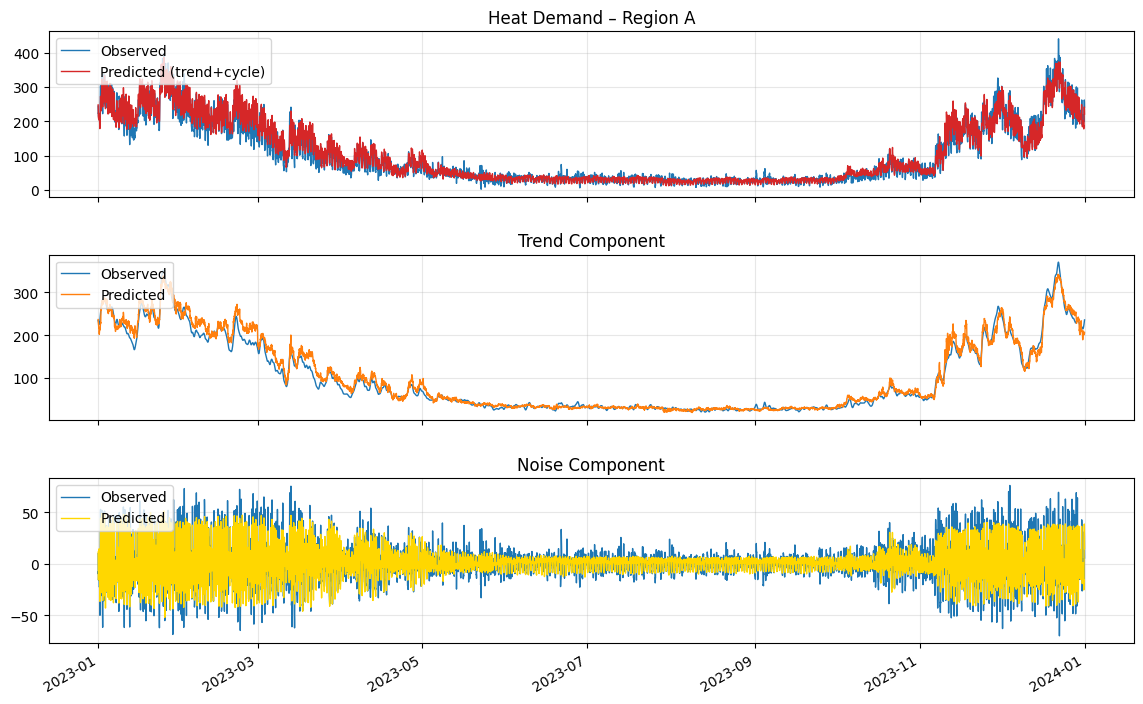

In [103]:
import matplotlib.pyplot as plt

def plot_heat_demand(
    df: pd.DataFrame,
    trend: pd.DataFrame,
    cycle: pd.DataFrame,
    region: str,
    lw: float = 1.0,
    show_obs_sum: bool = False,   # ← 실측 합 라인 표시 여부
) -> None:
    """
    지역별 Heat-Demand · Trend · Cycle   (실측 ↔ 예측) + 예측 합 비교.

    Parameters
    ----------
    df, trend, cycle : 이전과 동일
    region           : branch_ID
    lw               : 선 굵기
    show_obs_sum     : True 면 (trend+cycle) 실측 합도 표시
    """

    # ── 1. TM 타입 통일
    for _df in (df, trend, cycle):
        _df['TM'] = pd.to_datetime(_df['TM'])

    # ── 2. 필터링 · 병합
    region_df = df.query("branch_ID == @region").copy()
    if region_df.empty:
        raise ValueError(f"'{region}' 지역 데이터가 없습니다.")

    trend_pred = (
        trend.query("branch_ID == @region")[['TM', 'prediction']]
        .rename(columns={'prediction': 'trend_pred'})
    )
    cycle_pred = (
        cycle.query("branch_ID == @region")[['TM', 'prediction']]
        .rename(columns={'prediction': 'cycle_pred'})
    )

    plot_df = (
        region_df
        .merge(trend_pred, on='TM', how='left')
        .merge(cycle_pred, on='TM', how='left')
        .sort_values('TM')
    )

    # ── 3. 합계 계산
    plot_df['pred_sum'] = plot_df['trend_pred'] + plot_df['cycle_pred']
    if show_obs_sum:
        plot_df['obs_sum'] = (
            plot_df['heat_demand_trend'] + plot_df['heat_demand_cycle']
        )

    # ── 4. 플롯
    fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True,
                             gridspec_kw={'hspace': 0.35})

    # (a) Heat Demand: 실측 vs 예측 합
    axes[0].plot(
        plot_df['TM'], plot_df['heat_demand'],
        label='Observed', color='tab:blue', linewidth=lw
    )
    axes[0].plot(
        plot_df['TM'], plot_df['pred_sum'],
        label='Predicted (trend+cycle)', color='tab:red',
        linewidth=lw
    )
    if show_obs_sum:
        axes[0].plot(
            plot_df['TM'], plot_df['obs_sum'],
            label='Observed (trend+cycle)', color='tab:green',
            linewidth=lw, linestyle=':'
        )
    axes[0].set(title=f'Heat Demand – Region {region}')

    # (b) Trend: 실측 vs 예측
    axes[1].plot(
        plot_df['TM'], plot_df['heat_demand_trend'],
        label='Observed', color='tab:blue', linewidth=lw
    )
    axes[1].plot(
        plot_df['TM'], plot_df['trend_pred'],
        label='Predicted', color='tab:orange', linewidth=lw
    )
    axes[1].set(title='Trend Component')

    # (c) Cycle: 실측 vs 예측
    axes[2].plot(
        plot_df['TM'], plot_df['heat_demand_cycle'],
        label='Observed', color='tab:blue', linewidth=lw
    )
    axes[2].plot(
        plot_df['TM'], plot_df['cycle_pred'],
        label='Predicted', color='gold', linewidth=lw
    )
    axes[2].set(title='Noise Component')

    # ── 공통 옵션
    for ax in axes:
        ax.grid(alpha=0.3)
        ax.legend(loc='upper left')

    fig.autofmt_xdate()   # 날짜 라벨 자동 회전
    plt.show()

plot_heat_demand(val_data,trend,cycle,'A')

### test data 파생변수 처리

In [75]:
data1 = pd.read_csv("train_temporary_dtw.csv")
data2 = pd.read_csv('test_temporary_dtw.csv')
datafull = pd.concat([data1,data2])

In [76]:
data_test = datafull
# 요일 추출 (0=월요일, 6=일요일)
data_test['TM'] = pd.to_datetime(data_test['TM'], format='%Y%m%d%H')
data_test['year'] = data_test['TM'].dt.year
data_test['month'] = data_test['TM'].dt.month
data_test['day'] = data_test['TM'].dt.day
data_test['hour'] = data_test['TM'].dt.hour

data_test['weekday'] = data_test['TM'].dt.weekday

# 평일/주말 구분 (0=평일, 1=주말)
data_test['is_weekend'] = (data_test['weekday'] >= 5).astype(int)

# 한국 공휴일 설정
korea_holidays = holidays.Korea(years=range(2021, 2025))

# 공휴일 여부 (1=공휴일, 0=평일)
data_test['is_holiday'] = data_test['TM'].dt.date.apply(lambda x: x in korea_holidays).astype(int)

data_test.drop("weekday",axis=1, inplace=True)
data_test.head()

,TM,branch_ID,TA,WD,WS,RN_DAY,RN_HR1,HM,SI,ta_chi,heat_demand,year,month,day,hour,is_weekend,is_holiday
0,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,0.0,-8.2,281.0,2021,1,1,1,0,1
1,2021-01-01 02:00:00,A,-10.2,71.9,0.6,0.0,0.0,69.9,0.0,-8.6,262.0,2021,1,1,2,0,1
2,2021-01-01 03:00:00,A,-10.0,360.0,0.0,0.0,0.0,69.2,0.0,-8.8,266.0,2021,1,1,3,0,1
3,2021-01-01 04:00:00,A,-9.3,155.9,0.5,0.0,0.0,65.0,0.0,-8.9,285.0,2021,1,1,4,0,1
4,2021-01-01 05:00:00,A,-9.0,74.3,1.9,0.0,0.0,63.5,0.0,-9.2,283.0,2021,1,1,5,0,1


In [77]:
#Hour
data_test = add_fourier_features(data_test, col='hour', period=24, order=2, prefix='hour')

# Month
data_test = add_fourier_features(data_test, col='month', period=12, order=2, prefix='month')

data_test['days_in_month'] = data_test['TM'].dt.days_in_month

data_test = fourier_dom(data_test, order=2, prefix='day')

In [78]:
data_test['DI'] = calculate_DI(data_test['TA'], data_test['HM'])
data_test['Discomfort_level'] = data_test['DI'].apply(DI_level)

In [79]:
data_test = create_HDD_features(
    data_test,            # 원본 DataFrame
    branch_col="branch_ID",
    temp_col="TA",
    time_col="TM",
    base_temp=18,
    windows=(7, 30)  # 7일 및 30일 누적 HDD
)

In [80]:
# grouped by 'branch_ID'
for col, lags in lag_dict.items():
    for lag in lags:
        data_test[f"{col}_lag_{lag}"] = (
            data_test
            .groupby("branch_ID")[col]          # 그룹별 시계열
            .transform(lambda s: s.shift(lag))  # 그룹 내부에서만 shift
        )

In [81]:
data_test

,TM,branch_ID,TA,WD,WS,RN_DAY,RN_HR1,HM,SI,ta_chi,...,TA_lag_3,TA_lag_6,TA_lag_12,TA_lag_24,HM_lag_1,HM_lag_2,HM_lag_3,WS_lag_1,WS_lag_3,SI_lag_1
0,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,0.0,-8.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 02:00:00,A,-10.2,71.9,0.6,0.0,0.0,69.9,0.0,-8.6,...,NaN,NaN,NaN,NaN,68.2,NaN,NaN,0.5,NaN,0.0
2,2021-01-01 03:00:00,A,-10.0,360.0,0.0,0.0,0.0,69.2,0.0,-8.8,...,NaN,NaN,NaN,NaN,69.9,68.2,NaN,0.6,NaN,0.0
3,2021-01-01 04:00:00,A,-9.3,155.9,0.5,0.0,0.0,65.0,0.0,-8.9,...,-10.1,NaN,NaN,NaN,69.2,69.9,68.2,0.0,0.5,0.0
4,2021-01-01 05:00:00,A,-9.0,74.3,1.9,0.0,0.0,63.5,0.0,-9.2,...,-10.2,NaN,NaN,NaN,65.0,69.2,69.9,0.5,0.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166910,2024-12-31 20:00:00,S,-1.1,360.0,0.0,0.0,0.0,45.8,0.0,-1.7,...,1.1,3.3,-2.0,5.6,48.4,46.3,40.8,0.0,0.0,0.0
166911,2024-12-31 21:00:00,S,-1.3,360.0,0.0,0.0,0.0,48.3,0.0,-2.3,...,-0.3,2.5,-0.8,4.8,45.8,48.4,46.3,0.0,0.0,0.0
166912,2024-12-31 22:00:00,S,-2.4,360.0,0.0,0.0,0.0,60.0,0.0,-3.1,...,-1.0,2.1,0.4,4.7,48.3,45.8,48.4,0.0,0.0,0.0
166913,2024-12-31 23:00:00,S,-3.6,360.0,0.0,0.0,0.0,65.7,0.0,-3.9,...,-1.1,1.1,1.7,4.2,60.0,48.3,45.8,0.0,0.0,0.0


In [82]:
data_test = data_test[data_test['year'].isin([2024,2025])]
data_test

,TM,branch_ID,TA,WD,WS,RN_DAY,RN_HR1,HM,SI,ta_chi,...,TA_lag_3,TA_lag_6,TA_lag_12,TA_lag_24,HM_lag_1,HM_lag_2,HM_lag_3,WS_lag_1,WS_lag_3,SI_lag_1
0,2024-01-01 00:00:00,A,0.5,171.3,0.8,2.5,0.0,97.1,0.0,0.3,...,0.0,1.4,1.6,1.9,97.0,96.7,96.3,0.8,0.4,0.0
1,2024-01-01 01:00:00,A,0.4,93.7,1.0,0.0,0.0,96.8,0.0,0.1,...,0.0,1.1,1.9,2.1,97.1,97.0,96.7,0.8,0.4,0.0
2,2024-01-01 02:00:00,A,-0.1,133.0,0.8,0.0,0.0,97.0,0.0,0.0,...,-0.1,0.8,2.4,2.4,96.8,97.1,97.0,1.0,0.8,0.0
3,2024-01-01 03:00:00,A,-0.8,218.6,0.6,0.0,0.0,96.9,0.0,-0.2,...,0.5,0.0,3.7,2.3,97.0,96.8,97.1,0.8,0.8,0.0
4,2024-01-01 04:00:00,A,0.1,58.7,1.5,0.0,0.0,97.0,0.0,-0.1,...,0.4,0.0,4.1,2.2,96.9,97.0,96.8,0.6,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166910,2024-12-31 20:00:00,S,-1.1,360.0,0.0,0.0,0.0,45.8,0.0,-1.7,...,1.1,3.3,-2.0,5.6,48.4,46.3,40.8,0.0,0.0,0.0
166911,2024-12-31 21:00:00,S,-1.3,360.0,0.0,0.0,0.0,48.3,0.0,-2.3,...,-0.3,2.5,-0.8,4.8,45.8,48.4,46.3,0.0,0.0,0.0
166912,2024-12-31 22:00:00,S,-2.4,360.0,0.0,0.0,0.0,60.0,0.0,-3.1,...,-1.0,2.1,0.4,4.7,48.3,45.8,48.4,0.0,0.0,0.0
166913,2024-12-31 23:00:00,S,-3.6,360.0,0.0,0.0,0.0,65.7,0.0,-3.9,...,-1.1,1.1,1.7,4.2,60.0,48.3,45.8,0.0,0.0,0.0


In [83]:
# 타겟 변수와 피처 분리
target_col = 'heat_demand_cycle'
exclude_cols = ['TM', target_col, 'year','month', 'day','hour','Unnamed: 0','branch_ID',"WD","RN_DAY",'days_in_month', 'heat_demand_trend','heat_demand']
feature_cols = [col for col in data.columns if col not in exclude_cols]

In [84]:
data_test['branch_ID'] = data_test['branch_ID'].astype('category')

print(f"\nTarget 변수: {target_col}")
print(f"사용될 Feature 개수: {len(feature_cols)}")


Target 변수: heat_demand_cycle
사용될 Feature 개수: 36


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16588\3637666490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['branch_ID'] = data_test['branch_ID'].astype('category')


In [87]:
# 3단계: 2024년 데이터로 최종 예측
print("\n" + "=" * 60)
print("STEP 3: Making final predictions on 2024 test data")
print("=" * 60)

# 2024년 테스트 데이터 준비 (이미 전처리된 data_test 사용)
test_data_2024 = data_test.copy()
test_data_for_pred = test_data_2024.drop(columns=[target_col], errors='ignore')

# 최종 예측 수행
final_predictions = predict_with_final_models(test_data_for_pred, final_models, feature_cols)

# 예측 결과 저장
prediction_results = np.round(final_predictions['prediction'], 1)
pred_df = pd.DataFrame({'pred': final_predictions['prediction']})
pred_df.to_csv('2024_pred_cycle.csv', index=False)


STEP 3: Making final predictions on 2024 test data


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16588\2828539007.py:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for branch_id, group_data in data_pred_sorted.groupby('branch_ID'):


--- Predicting for branch_ID: A ---
--- Predicting for branch_ID: B ---
--- Predicting for branch_ID: C ---
--- Predicting for branch_ID: D ---
--- Predicting for branch_ID: E ---
--- Predicting for branch_ID: F ---
--- Predicting for branch_ID: G ---
--- Predicting for branch_ID: H ---
--- Predicting for branch_ID: I ---
--- Predicting for branch_ID: J ---
--- Predicting for branch_ID: K ---
--- Predicting for branch_ID: L ---
--- Predicting for branch_ID: M ---
--- Predicting for branch_ID: N ---
--- Predicting for branch_ID: O ---
--- Predicting for branch_ID: P ---
--- Predicting for branch_ID: Q ---
--- Predicting for branch_ID: R ---
--- Predicting for branch_ID: S ---


In [90]:
cycle = pd.read_csv('2024_pred_cycle.csv')
trend = pd.read_csv('2024_pred_trend.csv')
pred = cycle['pred'].values + trend['pred'].values
pred = np.round(pred, 1)
pred_df = pd.DataFrame({'prediction': pred})
pred_df.to_csv('2024_final_prediction.csv', index=False)